In [2]:
import torch 
import torch.nn as nn
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torch.utils.data import DataLoader
import torchvision.transforms as trnsfrms
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

In [3]:
transform = trnsfrms.Compose([
    trnsfrms.ToTensor(),
    trnsfrms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_x, train_y = torch.tensor(train_dataset.data).type(torch.float32).permute(0, 3, 1, 2), torch.tensor(train_dataset.targets)
test_x, test_y = torch.tensor(test_dataset.data).type(torch.float32).permute(0, 3, 1, 2), torch.tensor(test_dataset.targets)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

torch.Size([8, 3, 32, 32])


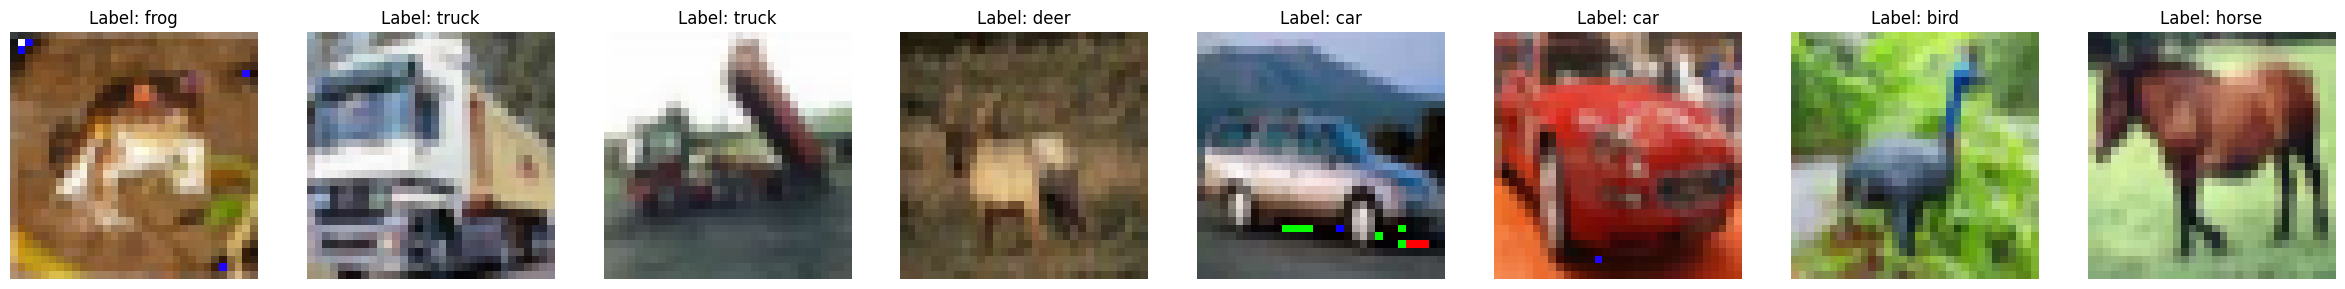

In [13]:
import PIL.ImageOps

class Flatten(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor):
        return x.view(x.size(0), -1)

def draw_sample(X, Y, num_images_to_show=5):
    print(X.shape)
    fig, axes = plt.subplots(1, num_images_to_show, figsize=(30, 12))
    pil = ToPILImage()
    for i in range(num_images_to_show):
        image, label = X[i], Y[i]
        image = pil(image)
        inverted_image = PIL.ImageOps.invert(image)
        axes[i].imshow(inverted_image)
        axes[i].set_title(f"Label: {classes[label]}")
        axes[i].axis('off')

    plt.show()

def draw_samples(X, y):
    images, labels = X[0:8], y[0:8]
    draw_sample(images, labels, 8)
    

draw_samples(train_x, train_y)


In [5]:
class CNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            Flatten(),
            nn.Linear(6 * 14 * 14, 120),
            nn.ReLU(),
            nn.Linear(120, 60),
            nn.ReLU(),
            nn.Linear(60, 10),
        )

    def forward(self, x):
        return self.model(x)
    
    def fit(self, X, Y, epochs, lr, batch_size=100, show_loss=True, show_period=1):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X, Y = X[indices], Y[indices]
            for i in range(X.shape[0] // batch_size):
                x, y = X[i * batch_size:(i + 1) * batch_size], Y[i * batch_size:(i + 1) * batch_size]
                optimizer.zero_grad()
                pred = self(x)
                loss = criterion(pred, y)
                loss.backward()
                optimizer.step()
            if show_loss and epoch % show_period == 0:
                print(f'epoch {epoch} loss: {loss}')
    
    def predict(self, X):
        return self(X).argmax(dim=1)

                

In [6]:
def draw_heatmap(y_pred, y_true):
    with torch.no_grad():
        conf_matr = confusion_matrix(y_true, y_pred)
        classes = y_true.unique().tolist()
        dataframe = pd.DataFrame(conf_matr, index=classes, columns=classes)
        sns.heatmap(dataframe, annot=True, cbar=False, cmap="YlGnBu",fmt="d")

epoch 0 loss: 2.3112635612487793
epoch 1 loss: 2.3043270111083984
epoch 2 loss: 2.2752084732055664
epoch 3 loss: 2.258241891860962
epoch 4 loss: 2.207737684249878
epoch 5 loss: 2.1507809162139893
epoch 6 loss: 2.122359037399292
epoch 7 loss: 2.0624351501464844
epoch 8 loss: 2.0271739959716797
epoch 9 loss: 1.9501785039901733
epoch 0 loss: 2.1487340927124023
epoch 1 loss: 2.030939817428589
epoch 2 loss: 1.9737613201141357
epoch 3 loss: 1.9750981330871582
epoch 4 loss: 1.8042030334472656
epoch 5 loss: 1.8389437198638916
epoch 6 loss: 1.7899572849273682
epoch 7 loss: 1.7872960567474365
epoch 8 loss: 1.8031617403030396
epoch 9 loss: 1.727041482925415
epoch 0 loss: 2.290661573410034
epoch 1 loss: 2.1893930435180664
epoch 2 loss: 2.189622163772583
epoch 3 loss: 2.1245884895324707
epoch 4 loss: 1.9954419136047363
epoch 5 loss: 2.0259315967559814
epoch 6 loss: 2.0806961059570312
epoch 7 loss: 2.0147156715393066
epoch 8 loss: 1.99167799949646
epoch 9 loss: 2.0276870727539062
epoch 0 loss: 2.535

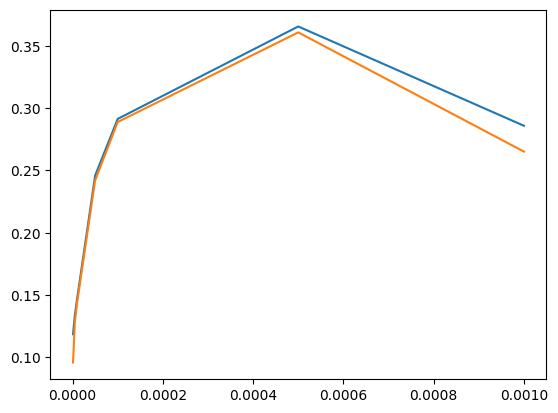

In [96]:
lrs = [0.001, 0.0005, 0.0001, 0.00005, 0.00001, 0.000005, 0.000001]
accuracy_scores = []
f1_scores = []

for lr in lrs:
    model = CNN1()
    model.fit(train_x, train_y, 10, lr, 500)
    with torch.no_grad():
        pred = model.predict(test_x).numpy()
        accuracy_scores.append(accuracy_score(test_y, pred))
        f1_scores.append(f1_score(test_y, pred, average='macro'))


plt.plot(lrs, accuracy_scores)
plt.plot(lrs, f1_scores)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (7,) and (10,)

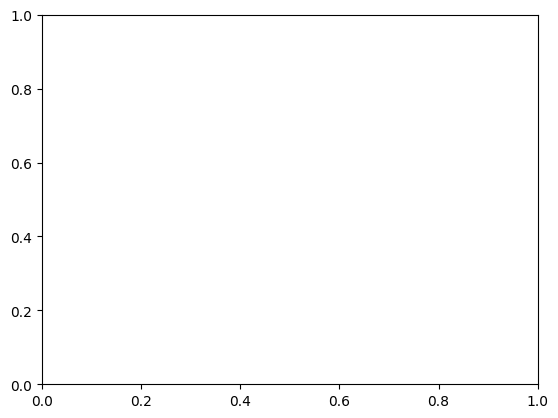

In [102]:
batch_sizes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
accuracy_scores = []
f1_scores = []

for batch_size in batch_sizes:
    model = CNN1()
    model.fit(train_x, train_y, 5, 0.0005, batch_size, False)
    with torch.no_grad():
        pred = model.predict(test_x).numpy()
        accuracy_scores.append(accuracy_score(test_y, pred))
        f1_scores.append(f1_score(test_y, pred, average='macro'))


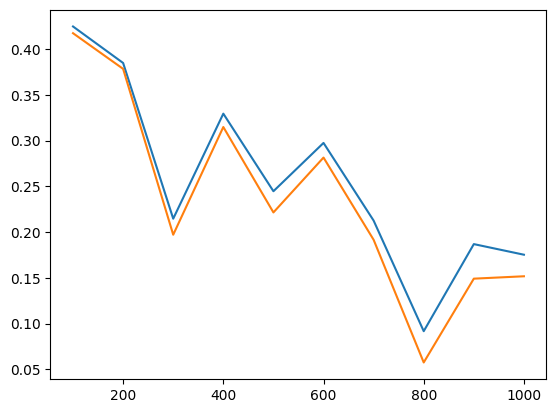

In [103]:
plt.plot(batch_sizes, accuracy_scores)
plt.plot(batch_sizes, f1_scores)
plt.show()

epoch 0 loss: 2.11696195602417
epoch 10 loss: 1.532131314277649
epoch 20 loss: 1.4715733528137207
epoch 30 loss: 1.4934085607528687
epoch 40 loss: 1.3993180990219116
epoch 50 loss: 1.332275390625
epoch 60 loss: 1.1354436874389648
epoch 70 loss: 1.1054728031158447
epoch 80 loss: 1.3522095680236816
epoch 90 loss: 1.3213822841644287
0.5455
0.5388571843148534


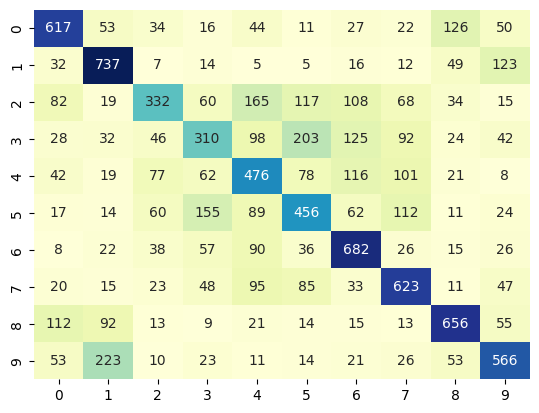

In [107]:
model = CNN1()
model.fit(train_x, train_y, 100, 0.0005, 200, True, 10)

with torch.no_grad():
    pred = model.predict(test_x).numpy()
    print(accuracy_score(test_y, pred))
    print(f1_score(test_y, pred, average='macro'))
    draw_heatmap(pred, test_y)

epoch 0 loss: 1.67206609249115
epoch 10 loss: 1.1807992458343506
epoch 20 loss: 1.0727728605270386
epoch 30 loss: 1.1603816747665405
epoch 40 loss: 1.0684112310409546
epoch 50 loss: 1.0317779779434204
epoch 60 loss: 0.8632242679595947
epoch 70 loss: 0.5511215925216675
epoch 80 loss: 0.49412235617637634
epoch 90 loss: 0.42413032054901123
0.5438
0.5441389084511411


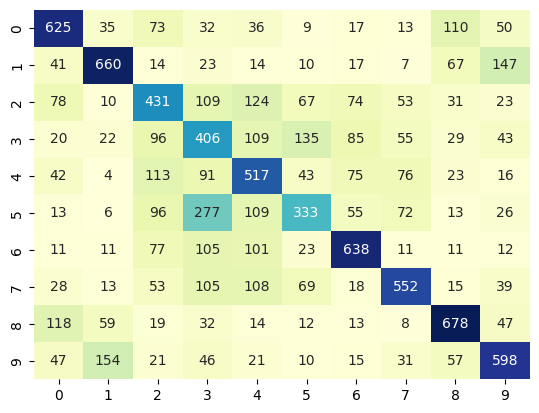

In [113]:
model = CNN1()
model.fit(train_x, train_y, 100, 0.0005, 50, True, 10)

with torch.no_grad():
    pred = model.predict(test_x).numpy()
    print(accuracy_score(test_y, pred))
    print(f1_score(test_y, pred, average='macro'))
    draw_heatmap(pred, test_y)

In [111]:
indices = np.random.permutation(train_x.shape[0])
train_x_batch, train_y_batch = train_x[indices], train_y[indices]
train_x_batch, train_y_batch = train_x_batch[:10000], train_y_batch[:10000]

epoch 0 loss: 2.081066370010376
epoch 10 loss: 1.1787195205688477
epoch 20 loss: 1.3292404413223267
epoch 30 loss: 1.1596099138259888
epoch 40 loss: 1.2624362707138062
epoch 50 loss: 0.8322151899337769
epoch 60 loss: 0.5877884030342102
epoch 70 loss: 0.5633198022842407
epoch 80 loss: 0.6193676590919495
epoch 90 loss: 0.34974804520606995
0.4581
0.4557913421339356


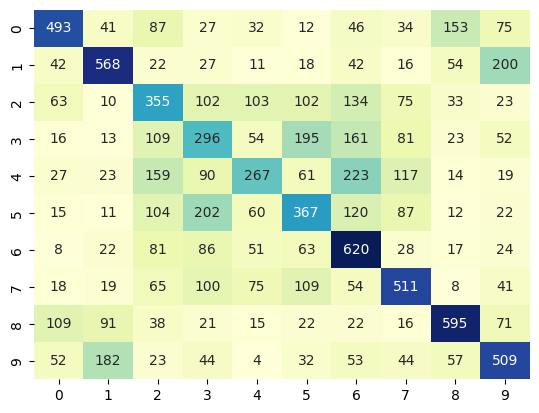

In [112]:
model = CNN1()
model.fit(train_x_batch, train_y_batch, 100, 0.0005, 50, True, 10)

with torch.no_grad():
    pred = model.predict(test_x).numpy()
    print(accuracy_score(test_y, pred))
    print(f1_score(test_y, pred, average='macro'))
    draw_heatmap(pred, test_y)

epoch 0 loss: 2.2293953895568848
epoch 10 loss: 1.765412449836731
epoch 20 loss: 1.2811954021453857
epoch 30 loss: 1.3650116920471191
epoch 40 loss: 0.8115183115005493
epoch 50 loss: 0.684164822101593
epoch 60 loss: 0.5344243049621582
epoch 70 loss: 0.8095999956130981
epoch 80 loss: 0.28269872069358826
epoch 90 loss: 0.18057085573673248
epoch 100 loss: 0.1856892704963684
epoch 110 loss: 0.05115644633769989
epoch 120 loss: 0.04218291863799095
epoch 130 loss: 0.018180998042225838
epoch 140 loss: 0.01672051101922989
epoch 150 loss: 0.04741092771291733
epoch 160 loss: 0.022013800218701363
epoch 170 loss: 0.01372151356190443
epoch 180 loss: 0.009704512543976307
epoch 190 loss: 0.006551791448146105
0.4473
0.4467727251181078


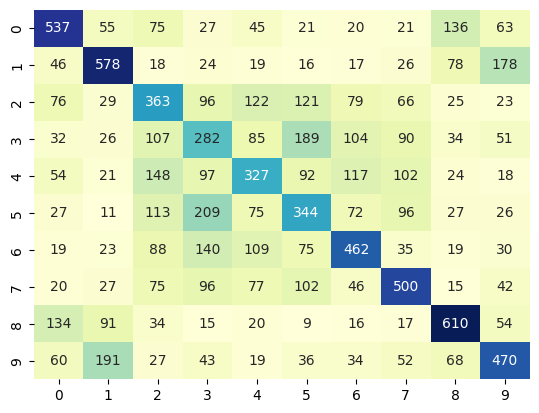

In [114]:
model = CNN1()
model.fit(train_x_batch, train_y_batch, 200, 0.0005, 50, True, 10)

with torch.no_grad():
    pred = model.predict(test_x).numpy()
    print(accuracy_score(test_y, pred))
    print(f1_score(test_y, pred, average='macro'))
    draw_heatmap(pred, test_y)

In [8]:
class CNN(nn.Module):
    def __init__(self, num_of_blocks, stride_conv, stride_pool, kernel_conv_size, kernel_pool_size, out_channels=6, in_channels=3):
        super().__init__()
        models = [nn.Conv2d(in_channels, out_channels, kernel_conv_size, stride=stride_conv),
            nn.ReLU(),
            nn.MaxPool2d(kernel_pool_size, stride=stride_pool),
            nn.ReLU()] + [nn.Conv2d(out_channels, out_channels, kernel_conv_size, stride=stride_conv),
            nn.ReLU(),
            nn.MaxPool2d(kernel_pool_size, stride=stride_pool),
            nn.ReLU()] * (num_of_blocks - 1) + [Flatten()]
        vect = torch.zeros(1, 3, 32, 32)
        for model in models:
            vect = model(vect)
        lin_dim = vect.shape[1]
        print(lin_dim)
        lin_dims = [lin_dim]
        for i in range(2):
            if lin_dim // 2 > 10:
                lin_dims.append(lin_dim // 2)
                lin_dim = lin_dim // 2
        self.model = nn.Sequential(
            *models,
            nn.Linear(lin_dims[0], lin_dims[1]),
            nn.ReLU(),
            nn.Linear(lin_dims[1], lin_dims[2]),
            nn.ReLU(),
            nn.Linear(lin_dims[2], 10),
        )

    def forward(self, x):
        return self.model(x)
    
    def fit(self, X, Y, epochs, lr, batch_size=100, show_loss=True, show_period=1):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X, Y = X[indices], Y[indices]
            for i in range(X.shape[0] // batch_size):
                x, y = X[i * batch_size:(i + 1) * batch_size], Y[i * batch_size:(i + 1) * batch_size]
                optimizer.zero_grad()
                pred = self(x)
                loss = criterion(pred, y)
                loss.backward()
                optimizer.step()
            if show_loss and epoch % show_period == 0:
                print(f'epoch {epoch} loss: {loss}')
    
    def predict(self, X):
        return self(X).argmax(dim=1)

In [7]:
def find_metric(model, train_x, train_y, epochs, batch_size, lr, show_loss=True, show_period=10, print_info=True, show_heatmap=True):
    model.fit(train_x, train_y, epochs, lr, batch_size, show_loss, show_period)
    accuracy_sc = accuracy_score(test_y, model.predict(test_x).numpy())
    f1_sc = f1_score(test_y, model.predict(test_x).numpy(), average='macro')
    if print_info:
        print(f'accuracy score: {accuracy_sc}')
        print(f'f1 score: {f1_sc}')
    if show_heatmap:
        draw_heatmap(model.predict(test_x).numpy(), test_y)
    return accuracy_sc, f1_sc

1350
accuracy score: 0.5056
f1 score: 0.49619799795211855
1176
accuracy score: 0.4938
f1 score: 0.48862950663937543
1014
accuracy score: 0.465
f1 score: 0.4530151950897017
864
accuracy score: 0.4101
f1 score: 0.39970562562525674
726
accuracy score: 0.3343
f1 score: 0.32876726374610304
600
accuracy score: 0.3329
f1 score: 0.3218277313231489


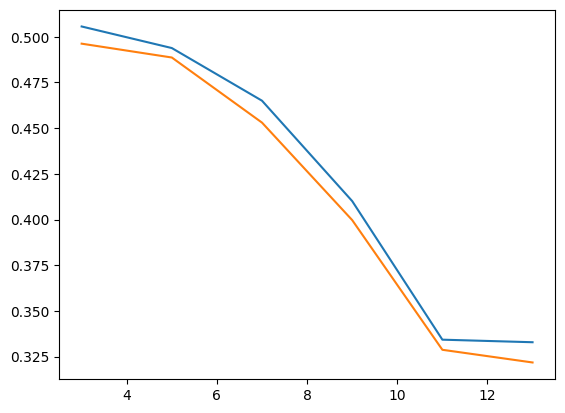

In [27]:
conv_kernel_sizes = [3, 5, 7, 9, 11, 13]
accs = []
f1_scores = []
for conv_kernel_size in conv_kernel_sizes:
    model = CNN(num_of_blocks=1, stride_conv=1, stride_pool=2, kernel_conv_size=conv_kernel_size, kernel_pool_size=2)
    acc, f1 = find_metric(model, train_x, train_y, 10, 100, 0.0005, show_heatmap=False, show_loss=False)
    accs.append(acc)
    f1_scores.append(f1)

plt.plot(conv_kernel_sizes, accs)
plt.plot(conv_kernel_sizes, f1_scores)
plt.show()
    

1350
epoch 0 loss: 1.5900592803955078
accuracy score: 0.545
f1 score: 0.5469529331707433
294
epoch 0 loss: 1.8220138549804688
accuracy score: 0.5264
f1 score: 0.5269820518211498
150
epoch 0 loss: 1.0394189357757568
accuracy score: 0.4699
f1 score: 0.4629700425942981


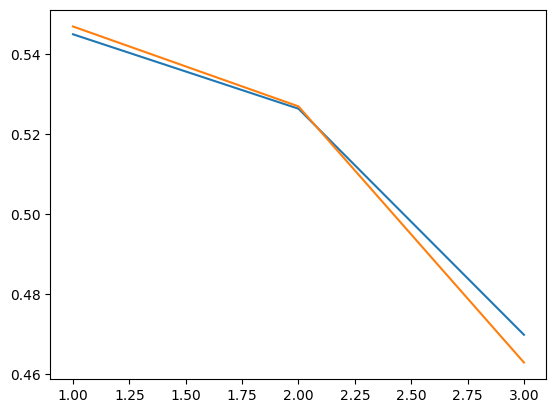

In [31]:
conv_strides = [1, 2, 3]
accs = []
f1_scores = []
for conv_stride in conv_strides:
    model = CNN(num_of_blocks=1, stride_conv=conv_stride, stride_pool=2, kernel_conv_size=3, kernel_pool_size=2)
    acc, f1 = find_metric(model, train_x, train_y, 10, 10, 0.0005, show_heatmap=False)
    accs.append(acc)
    f1_scores.append(f1)

plt.plot(conv_strides, accs)
plt.plot(conv_strides, f1_scores)
plt.show()

5046
accuracy score: 0.4928
f1 score: 0.48668515512924804
1350
accuracy score: 0.4856
f1 score: 0.48096889993681025
600
accuracy score: 0.395
f1 score: 0.3867182412155847


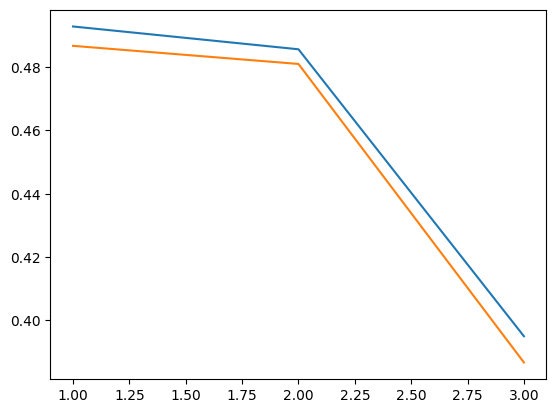

In [35]:
pool_strides = [1, 2, 3]
accs = []
f1_scores = []
for pool_stride in pool_strides:
    model = CNN(num_of_blocks=1, stride_conv=1, stride_pool=pool_stride, kernel_conv_size=3, kernel_pool_size=2)
    acc, f1 = find_metric(model, train_x, train_y, 10, 100, 0.0005, show_heatmap=False, show_loss=False)
    accs.append(acc)
    f1_scores.append(f1)

plt.plot(pool_strides, accs)
plt.plot(pool_strides, f1_scores)
plt.show()

1350
accuracy score: 0.4927
f1 score: 0.4855370197884275
1176
accuracy score: 0.4614
f1 score: 0.4411722239263246
1176
accuracy score: 0.5399
f1 score: 0.5362869828968295
1014
accuracy score: 0.5173
f1 score: 0.5130375870609365
1014
accuracy score: 0.5076
f1 score: 0.5049416965669986
864
accuracy score: 0.4996
f1 score: 0.4935177135374829


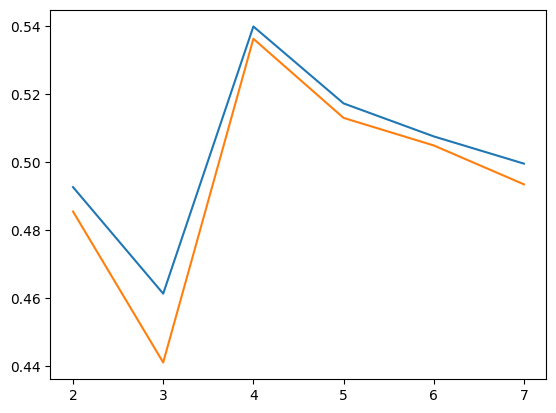

In [14]:
pool_kernel_sizes = [2, 3, 4, 5, 6, 7]
accs = []
f1_scores = []
for pool_kernel_size in pool_kernel_sizes:
    model = CNN(num_of_blocks=1, stride_conv=1, stride_pool=2, kernel_conv_size=3, kernel_pool_size=pool_kernel_size)
    acc, f1 = find_metric(model, train_x, train_y, 10, 100, 0.0005, show_heatmap=False, show_loss=False)
    accs.append(acc)
    f1_scores.append(f1)

plt.plot(pool_kernel_sizes, accs)
plt.plot(pool_kernel_sizes, f1_scores)
plt.show()

1176
accuracy score: 0.55
f1 score: 0.5446437246755929
150
accuracy score: 0.0944
f1 score: 0.027774762355449602


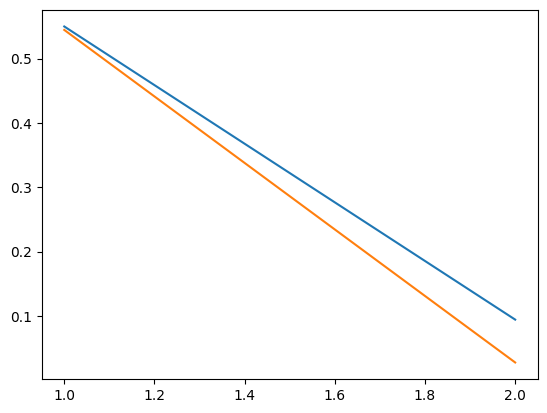

In [18]:
blocks_nums = [1, 2]
accs = []
f1_scores = []
for num_of_blocks in blocks_nums:
    model = CNN(num_of_blocks=num_of_blocks, stride_conv=1, stride_pool=2, kernel_conv_size=3, kernel_pool_size=4)
    acc, f1 = find_metric(model, train_x, train_y, 10, 100, 0.0005, show_heatmap=False, show_loss=False)
    accs.append(acc)
    f1_scores.append(f1)

plt.plot(blocks_nums, accs)
plt.plot(blocks_nums, f1_scores)

1176
epoch 0 loss: 1.5481754541397095
epoch 10 loss: 1.3361811637878418
accuracy score: 0.5815
f1 score: 0.5807649352443425


(0.5815, 0.5807649352443425)

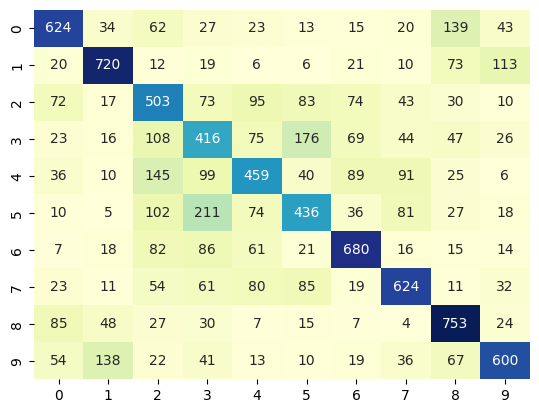

In [20]:
model = CNN(num_of_blocks=1, stride_conv=1, stride_pool=2, kernel_conv_size=3, kernel_pool_size=4)
find_metric(model, train_x, train_y, 20, 100, 0.0005, show_heatmap=True, show_loss=True)

1176
epoch 0 loss: 1.9905222654342651
epoch 5 loss: 1.5375566482543945
epoch 10 loss: 1.632310152053833
epoch 15 loss: 1.4511321783065796
epoch 20 loss: 1.2111643552780151
epoch 25 loss: 1.2680803537368774
epoch 30 loss: 1.230339765548706
epoch 35 loss: 1.2844864130020142
epoch 40 loss: 0.9404644966125488
epoch 45 loss: 0.9224769473075867
epoch 50 loss: 0.9078888893127441
epoch 55 loss: 0.7672006487846375
epoch 60 loss: 0.7012686729431152
epoch 65 loss: 0.865796685218811
epoch 70 loss: 0.5412271022796631
epoch 75 loss: 0.6145921945571899
epoch 80 loss: 0.479095995426178
epoch 85 loss: 0.4823998510837555
epoch 90 loss: 0.41827067732810974
epoch 95 loss: 0.293585866689682
accuracy score: 0.5692
f1 score: 0.5654621358387957


(0.5692, 0.5654621358387957)

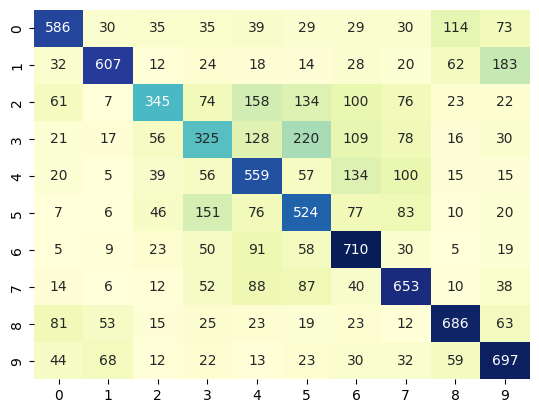

In [22]:
model = CNN(num_of_blocks=1, stride_conv=1, stride_pool=2, kernel_conv_size=3, kernel_pool_size=4)
find_metric(model, train_x, train_y, 100, 100, 0.0005, show_heatmap=True, show_loss=True, show_period=5)

6272
epoch 0 loss: 1.5670347213745117
epoch 1 loss: 1.4816476106643677
epoch 2 loss: 1.3254584074020386
epoch 3 loss: 1.1242492198944092
epoch 4 loss: 0.9976202249526978
epoch 5 loss: 0.9712936282157898
epoch 6 loss: 0.8863479495048523
epoch 7 loss: 0.9365302324295044
epoch 8 loss: 0.7437088489532471
epoch 9 loss: 0.8825904130935669
accuracy score: 0.6435
f1 score: 0.6415436189774061


(0.6435, 0.6415436189774061)

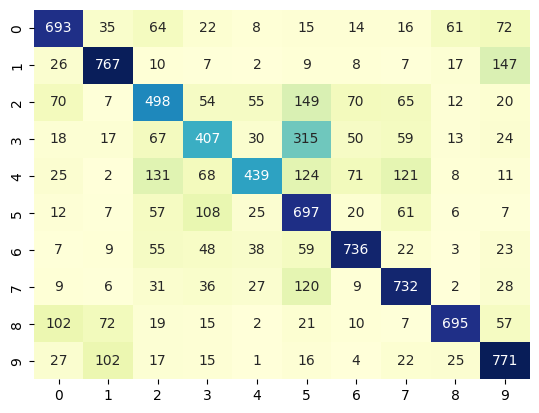

In [27]:
model = CNN(num_of_blocks=1, stride_conv=1, stride_pool=2, kernel_conv_size=3, kernel_pool_size=4, out_channels=32)
find_metric(model, train_x, train_y, 10, 100, 0.0005, show_heatmap=True, show_loss=True, show_period=1)

800
epoch 0 loss: 1.696271538734436
epoch 1 loss: 1.659693956375122
epoch 2 loss: 1.637497901916504
epoch 3 loss: 1.4919095039367676
epoch 4 loss: 1.4546215534210205
epoch 5 loss: 1.1598014831542969
epoch 6 loss: 1.3582673072814941
epoch 7 loss: 1.2452524900436401
epoch 8 loss: 1.306434988975525
epoch 9 loss: 1.1465176343917847
accuracy score: 0.5764
f1 score: 0.5713078118898379


(0.5764, 0.5713078118898379)

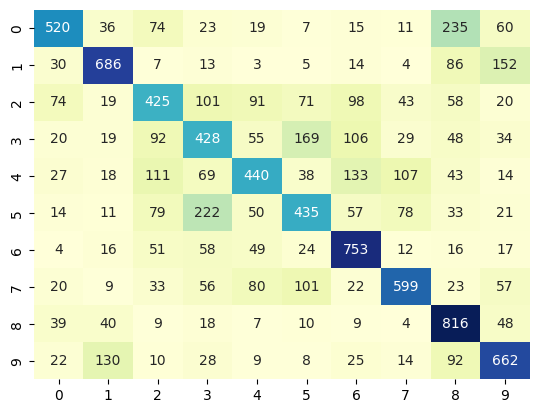

In [26]:
model = CNN(num_of_blocks=2, stride_conv=1, stride_pool=2, kernel_conv_size=3, kernel_pool_size=4, out_channels=32)
find_metric(model, train_x, train_y, 10, 100, 0.0005, show_heatmap=True, show_loss=True, show_period=1)

In [10]:
class CNN2(nn.Module):
    def __init__(self, num_of_blocks, stride_conv, stride_pool, kernel_conv_size, kernel_pool_size, out_channels=6, in_channels=3):
        super().__init__()
        models = [nn.Conv2d(in_channels, out_channels, kernel_conv_size, stride=stride_conv),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_conv_size, stride=stride_conv),
            nn.ReLU(),
            nn.MaxPool2d(kernel_pool_size, stride=stride_pool),
            nn.ReLU()] + [nn.Conv2d(out_channels, out_channels, kernel_conv_size, stride=stride_conv),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_conv_size, stride=stride_conv),
            nn.ReLU(),
            nn.MaxPool2d(kernel_pool_size, stride=stride_pool),
            nn.ReLU()] * (num_of_blocks - 1) + [Flatten()]
        vect = torch.zeros(1, 3, 32, 32)
        for model in models:
            vect = model(vect)
        lin_dim = vect.shape[1]
        print(lin_dim)
        lin_dims = [lin_dim]
        for i in range(2):
            if lin_dim // 2 > 10:
                lin_dims.append(lin_dim // 2)
                lin_dim = lin_dim // 2
        self.model = nn.Sequential(
            *models,
            nn.Linear(lin_dims[0], lin_dims[1]),
            nn.ReLU(),
            nn.Linear(lin_dims[1], lin_dims[2]),
            nn.ReLU(),
            nn.Linear(lin_dims[2], 10),
        )

    def forward(self, x):
        return self.model(x)
    
    def fit(self, X, Y, epochs, lr, batch_size=100, show_loss=True, show_period=1):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X, Y = X[indices], Y[indices]
            for i in range(X.shape[0] // batch_size):
                x, y = X[i * batch_size:(i + 1) * batch_size], Y[i * batch_size:(i + 1) * batch_size]
                optimizer.zero_grad()
                pred = self(x)
                loss = criterion(pred, y)
                loss.backward()
                optimizer.step()
            if show_loss and epoch % show_period == 0:
                print(f'epoch {epoch} loss: {loss}')
    
    def predict(self, X):
        return self(X).argmax(dim=1)

5408
epoch 0 loss: 1.5352087020874023
epoch 1 loss: 1.4391003847122192
epoch 2 loss: 1.2864032983779907
epoch 3 loss: 1.1281486749649048
epoch 4 loss: 0.9106491208076477
epoch 5 loss: 1.1095424890518188
epoch 6 loss: 0.8560647368431091
epoch 7 loss: 0.8145264983177185
epoch 8 loss: 0.9508259296417236
epoch 9 loss: 0.8479740023612976
accuracy score: 0.6545
f1 score: 0.6528848880418774


(0.6545, 0.6528848880418774)

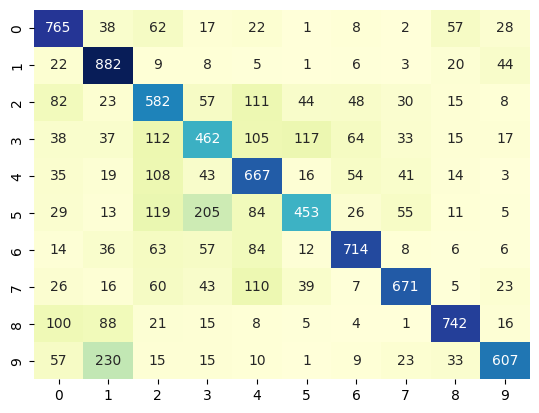

In [11]:
model = CNN2(num_of_blocks=1, stride_conv=1, stride_pool=2, kernel_conv_size=3, kernel_pool_size=4, out_channels=32)
find_metric(model, train_x, train_y, 10, 100, 0.0005, show_heatmap=True, show_loss=True, show_period=1)

5408
epoch 0 loss: 1.5687599182128906
epoch 1 loss: 1.3523461818695068
epoch 2 loss: 1.357690453529358
epoch 3 loss: 1.1898587942123413
epoch 4 loss: 1.2370429039001465
epoch 5 loss: 1.2234461307525635
epoch 6 loss: 1.4890718460083008
epoch 7 loss: 1.125293493270874
epoch 8 loss: 1.0084320306777954
epoch 9 loss: 0.9472684264183044
epoch 10 loss: 0.9914125800132751
epoch 11 loss: 0.8388686180114746
epoch 12 loss: 0.9962027668952942
epoch 13 loss: 0.8242353796958923
epoch 14 loss: 0.8195672631263733
accuracy score: 0.6468
f1 score: 0.639549278286615


(0.6468, 0.639549278286615)

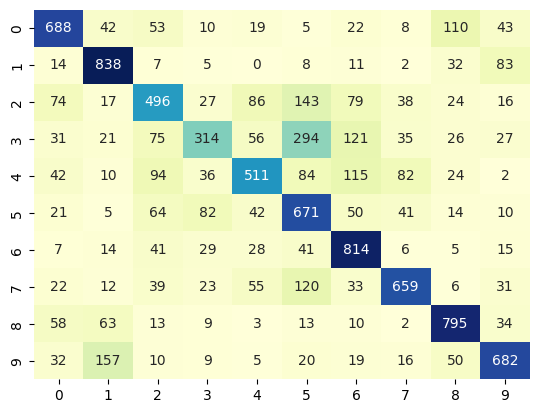

In [12]:
model = CNN2(num_of_blocks=1, stride_conv=1, stride_pool=2, kernel_conv_size=3, kernel_pool_size=4, out_channels=32)
find_metric(model, train_x, train_y, 15, 200, 0.0005, show_heatmap=True, show_loss=True, show_period=1)